<a href="https://colab.research.google.com/github/Kateryna-km/Subspots/blob/master/Sunspots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Методи нелінійної динаміки в інтелектуальному аналізі сонячної активності на підставі чисел Вольфа***

Імпорт необхідних бібліотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress, skew, kurtosis, weibull_min 

from scipy.spatial.distance import euclidean
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import fcluster

Підключення до Google disk, для доступу до файлу з числами Вольфа

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive/Sunspot_data/

Mounted at /content/drive
/content/drive/MyDrive/Sunspot_data


Завантаження файлу *Sunspots.csv* з числами Вольфа

In [3]:
df = pd.read_csv("Sunspots.csv",parse_dates = True)
df

,Year,Mounth,Date in fraction of year,Monthly mean total sunspot number,Monthly mean standard deviation,Number of observations,Definitive marker
0,1749,1,1749.042,96.7,-1.0,-1,1
1,1749,2,1749.123,104.3,-1.0,-1,1
2,1749,3,1749.204,116.7,-1.0,-1,1
3,1749,4,1749.288,92.8,-1.0,-1,1
4,1749,5,1749.371,141.7,-1.0,-1,1
...,...,...,...,...,...,...,...
3283,2022,8,2022.623,75.4,10.5,1289,0
3284,2022,9,2022.705,96.3,16.2,1130,0
3285,2022,10,2022.790,95.4,15.5,1028,0
3286,2022,11,2022.873,77.6,14.1,881,0


Створення поля з датою потрібного формату для подальшої роботи, поділу даних на цикли

In [4]:
df['Date'] = '1/' + df['Mounth'].astype(str) + '/' + df['Year'].astype(str)
df['Date']= pd.to_datetime(df['Date'])
df

,Year,Mounth,Date in fraction of year,Monthly mean total sunspot number,Monthly mean standard deviation,Number of observations,Definitive marker,Date
0,1749,1,1749.042,96.7,-1.0,-1,1,1749-01-01
1,1749,2,1749.123,104.3,-1.0,-1,1,1749-01-02
2,1749,3,1749.204,116.7,-1.0,-1,1,1749-01-03
3,1749,4,1749.288,92.8,-1.0,-1,1,1749-01-04
4,1749,5,1749.371,141.7,-1.0,-1,1,1749-01-05
...,...,...,...,...,...,...,...,...
3283,2022,8,2022.623,75.4,10.5,1289,0,2022-01-08
3284,2022,9,2022.705,96.3,16.2,1130,0,2022-01-09
3285,2022,10,2022.790,95.4,15.5,1028,0,2022-01-10
3286,2022,11,2022.873,77.6,14.1,881,0,2022-01-11


Графік вхідних даних

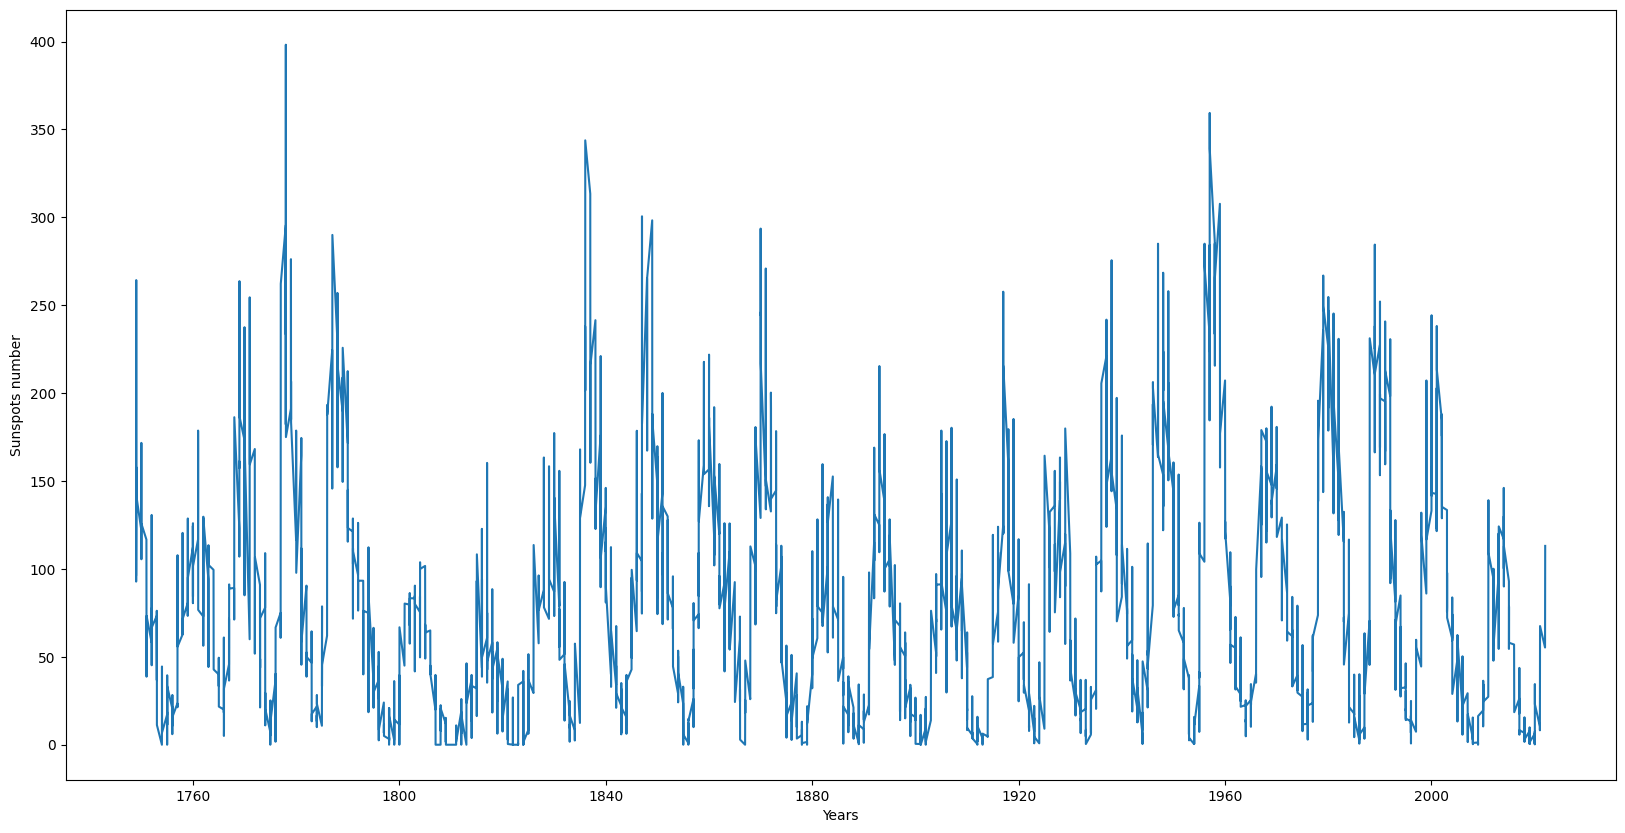

In [5]:
plt.figure(figsize=(20, 10))
x = df['Date']
y = df['Monthly mean total sunspot number']
plt.plot(x, y)

plt.xlabel('Years')
plt.ylabel('Sunspots number')

plt.show()


## Розподіл на цикли та виділення гілок росту й спаду

Поділ даних на цикли.
starts - перелік початків циклів із сайту:

https://www.sidc.be/silso/DATA/Cycles/TableCyclesMiMa.txt


In [6]:
starts = ['1755-01-02',
          '1766-01-06',
          '1775-01-06',
          '1784-01-09',
          '1798-01-04',
          '1810-01-07',
          '1823-01-05',
          '1833-01-11',
          '1843-01-07',
          '1855-01-12',
          '1867-01-03',
          '1878-01-12',
          '1890-01-03',
          '1902-01-01',
          '1913-01-07',
          '1923-01-08',
          '1933-01-09',
          '1944-01-02',
          '1954-01-04',
          '1964-01-10',
          '1976-01-03',
          '1986-01-09',
          '1996-01-08',
          '2008-01-12',
          '2019-01-12']

cycle = []
for i in range(len(starts)):
  if i + 1 < len(starts):
    cycle.append(df['Monthly mean total sunspot number'][(df['Date'] > pd.to_datetime(starts[i])) & (df['Date'] <= pd.to_datetime(starts[i+1]))])
  else:
    cycle.append(df['Monthly mean total sunspot number'][df['Date'] > pd.to_datetime(starts[i])])


Поділ даних на гілки зростання (cycle_L) та спадання (cycle_R). Дані максимумів maxs взяті з того ж сайту

In [7]:
maxs = ['1761-01-06',
        '1769-01-09',
        '1778-01-05',
        '1788-01-02',
        '1805-01-02',
        '1816-01-05',
        '1829-01-11',
        '1837-01-03',
        '1848-01-02',
        '1860-01-02',
        '1870-01-08',
        '1883-01-12',
        '1894-01-01',
        '1906-01-02',
        '1917-01-08',
        '1928-01-04',
        '1937-01-04',
        '1947-01-05',
        '1958-01-03',
        '1968-01-11',
        '1979-01-12',
        '1989-01-11',
        '2001-01-11',
        '2014-01-04']


cycle_L = []
cycle_R = []
for i in range(len(maxs)):
  cycle_L.append(df['Monthly mean total sunspot number'][(df['Date'] > pd.to_datetime(starts[i])) & (df['Date'] <= pd.to_datetime(maxs[i]))])
  cycle_R.append(df['Monthly mean total sunspot number'][(df['Date'] > pd.to_datetime(maxs[i])) & (df['Date'] <= pd.to_datetime(starts[i+1]))])
cycle_L.append(df['Monthly mean total sunspot number'][df['Date'] > pd.to_datetime(starts[-1])])

# Фрактальні характеристики циклів 

Функція для визначення фрактальної розмірності D клітинковим методом.

In [8]:
def box_counting(cycle):
    P = [2, 3, 4, 5, 6]
    cell = []
    cell_count = []
    for p in P:
        cell.append([])
        for i in range(len(cycle)):
            tmp = cycle[i:i+p]
            cell[-1].append((max(tmp) - min(tmp))/(p*10))
        
        cell_count.append(np.sum(cell[-1] * np.logical_not(np.mod(np.arange(1, len(cell[-1]) + 1) - 1, p))))
    
    log_size = []
    log_count = []
    for i in range(len(P)):
        log_size.append(np.log(P[i]))
        log_count.append(np.log(cell_count[i]))

    log_size = np.array(log_size)
    log_count = np.array(log_count)

    # Виконання лінійної регресії для знаходження нахилу лінії регресії
    slope, intercept, r_value, p_value, std_err = linregress(log_size, log_count)

    # Фрактальна розмірність - це протилежне значення нахилу лінії регресії
    fractal_dimension = -slope

    return fractal_dimension


Функція для створення таблиці фрактальних характеристик циклів сонячної активності. На вхід приймає числа Вольфа одного циклу і повертає обраховані:

Обсяг даних циклу N,

Розмах кумулят. суми R,	

Середньо-квадр. відхил. S,	

Фрактальна розмірність	D, 

Експонента Герста H,	

Фрактальна константа C.

In [9]:
def fract_calcul(cycle):
    cycle = np.array(cycle)
    N = len(cycle)

    cums = []
    avg = np.mean(cycle)
    for i in range(len(cycle)):
        if i > 0:
            cums.append(cycle[i] - avg + cums[-1])
        else:
            cums.append(cycle[i] - avg)

    R = np.ptp(cums)
    S = np.std(cycle)
    D = box_counting(cycle)
    H = 2 - D
    C = R / (S * (N ** H))

    return pd.Series({'N': N,
                      'R': R,
                      'S': S,
                      'D': D,
                      'H': H,
                      'C': C})



Побудова таблиці фрактальних характеристик циклів сонячної активності та гілок зростання і спадання за допомогою попередньої функції.

In [10]:
fract = pd.DataFrame([fract_calcul(c) for c in cycle])
fract

,N,R,S,D,H,C
0,136.0,2216.729412,41.941998,1.191458,0.808542,0.995424
1,108.0,2599.359259,64.288180,0.965069,1.034931,0.317894
2,111.0,4120.349550,87.072189,1.150431,0.849569,0.865788
3,163.0,5088.780368,74.824865,1.154651,0.845349,0.917272
4,147.0,2041.039456,31.018481,1.104002,0.895998,0.752175
5,154.0,1714.152597,29.974869,1.133180,0.866820,0.726282
6,126.0,2320.766667,44.555955,1.238683,0.761317,1.311227
7,116.0,3812.608621,79.476988,1.030121,0.969879,0.477207
8,149.0,3874.193289,68.334975,1.190526,0.809474,0.987189
9,135.0,3260.786667,60.225164,1.129113,0.870887,0.755551


Гістограма фрактальних показників повних циклів

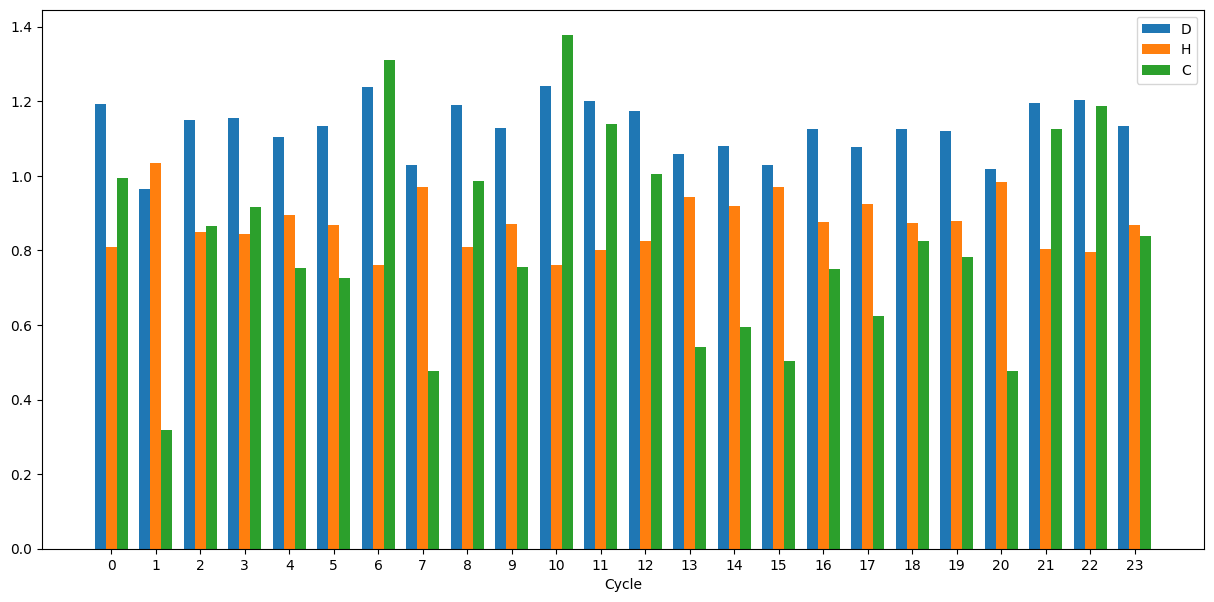

In [11]:
ind = np.arange(24)
width = 0.25

fig, ax = plt.subplots(figsize=(15, 7))
rects1 = ax.bar(ind - width, fract.D[:24], width, label='D')
rects2 = ax.bar(ind, fract.H[:24], width, label='H')
rects3 = ax.bar(ind + width, fract.C[:24], width, label='C')

ax.set_xticks(ind)
ax.set_xticklabels(ind)
ax.set_xlabel('Cycle')

ax.legend()

plt.show()

In [12]:
fract_L = pd.DataFrame([fract_calcul(c) for c in cycle_L])
fract_L


,N,R,S,D,H,C
0,76.0,1331.830263,43.046149,1.167678,0.832322,0.841534
1,39.0,884.020513,57.793602,0.781479,1.218521,0.176132
2,35.0,1528.020000,100.804963,0.903707,1.096293,0.307536
3,41.0,1554.751220,85.112185,0.995717,1.004283,0.438509
4,82.0,1120.328049,31.588813,1.079341,0.920659,0.613537
5,70.0,733.614286,30.166347,1.154546,0.845454,0.669885
6,78.0,1454.892308,44.241088,1.256400,0.743600,1.288381
7,40.0,1660.145000,94.573027,0.927419,1.072581,0.335768
8,55.0,1389.630909,70.344889,1.230126,0.769874,0.903248
9,50.0,1495.120000,68.644503,1.030529,0.969471,0.490872


In [13]:
fract_R = pd.DataFrame([fract_calcul(c) for c in cycle_R])
fract_R

,N,R,S,D,H,C
0,60.0,892.186667,40.420566,1.209831,0.790169,0.868586
1,69.0,1700.297101,67.481066,1.112358,0.887642,0.587630
2,76.0,2568.700000,79.766636,1.204010,0.795990,1.025140
3,122.0,3389.814754,68.892130,1.161106,0.838894,0.874525
4,65.0,674.690769,24.444748,1.118920,0.881080,0.697586
5,84.0,893.846429,29.254867,1.069308,0.930692,0.494485
6,48.0,853.708333,44.904970,1.165130,0.834870,0.750581
7,76.0,2157.100000,70.117378,1.069133,0.930867,0.546081
8,94.0,2419.665957,66.224223,1.066032,0.933968,0.524686
9,85.0,1755.665882,54.395146,1.142466,0.857534,0.715056


## Побудова таблиць із описовою статистикою

Таблиці з описовою статистикою і параметрами розподілу Вейбула для повних циклів (table), для гілок зростання (table_L) та для гілок спадання (table_R).

**mean** - середнє значення

**med** - медіана

**std** - стандартне відхилення

**A** - асиметрія

**E** - ексцес

**len** - обсяг вибірки

**max** - максимальне значення

**min** - мінімальне значення

**Q1** - перший квартиль

**Q3** - третій квартиль

**alfa** - параметр форми

**beta** - масштабний коефіцієнт

**mu** - параметр зсуву

In [14]:
table = pd.DataFrame({'mean': [i.mean() for i in np.array(cycle, dtype=object)],
                      'med': [i.median() for i in np.array(cycle, dtype=object)],
                      'std': [i.std() for i in np.array(cycle, dtype=object)],
                      'A': [skew(i) for i in np.array(cycle, dtype=object)],
                      'E': [kurtosis(i) for i in np.array(cycle, dtype=object)],
                      'len': [len(i) for i in np.array(cycle, dtype=object)],
                      'max': [max(i) for i in np.array(cycle, dtype=object)],
                      'min': [min(i) for i in np.array(cycle, dtype=object)],
                      'Q1': [np.quantile(i, 0.25) for i in np.array(cycle, dtype=object)],
                      'Q3': [np.quantile(i, 0.75) for i in np.array(cycle, dtype=object)],
                      'alfa': [weibull_min.fit(i)[0] for i in np.array(cycle, dtype=object)],
                      'beta': [weibull_min.fit(i)[1] for i in np.array(cycle, dtype=object)],
                      'mu': [weibull_min.fit(i)[2] for i in np.array(cycle, dtype=object)]})
table

,mean,med,std,A,E,len,max,min,Q1,Q3,alfa,beta,mu
0,69.433824,66.35,42.097052,0.371402,-0.609937,136,178.7,0.0,36.350,99.700,1.810528,-4.929962e+00,83.503893
1,99.095370,89.00,64.587893,0.549382,-0.362985,108,263.7,0.0,49.475,141.600,1.583859,-3.798741e+00,114.243246
2,111.185586,88.30,87.467076,0.694959,-0.299464,111,398.2,1.7,37.300,178.100,1.139028,1.276767e+00,114.775072
3,103.184049,92.80,75.055451,0.478118,-0.896301,163,290.0,1.8,35.350,157.250,1.220441,1.276166e+00,108.172423
4,38.678912,39.70,31.124527,0.264361,-1.279910,147,103.8,0.0,10.350,65.650,0.649066,-2.527529e-25,33.475048
5,30.525325,24.80,30.072667,1.242990,1.864050,154,160.3,0.0,3.850,47.175,0.875941,-2.640160e-27,32.526738
6,63.144444,64.60,44.733824,0.331539,-0.727599,126,177.3,0.0,25.075,92.425,1.352886,-3.397298e+00,71.988435
7,112.308621,101.70,79.821792,0.558904,-0.481456,116,343.8,2.4,41.150,168.700,1.295889,1.470107e+00,119.344759
8,99.413423,89.00,68.565448,0.752719,0.096718,149,300.6,0.0,42.600,135.500,1.455605,-1.982360e+00,111.520951
9,92.251111,80.60,60.449467,0.256280,-0.989728,135,221.9,0.0,41.950,143.500,1.622066,-7.209494e+00,110.593689


In [15]:
table_L = pd.DataFrame({'mean': [i.mean() for i in np.array(cycle_L, dtype=object)],
                      'med': [i.median() for i in np.array(cycle_L, dtype=object)],
                      'std': [i.std() for i in np.array(cycle_L, dtype=object)],
                      'A': [skew(i) for i in np.array(cycle_L, dtype=object)],
                      'E': [kurtosis(i) for i in np.array(cycle_L, dtype=object)],
                      'len': [len(i) for i in np.array(cycle_L, dtype=object)],
                      'max': [max(i) for i in np.array(cycle_L, dtype=object)],
                      'min': [min(i) for i in np.array(cycle_L, dtype=object)],
                      'Q1': [np.quantile(i, 0.25) for i in np.array(cycle_L, dtype=object)],
                      'Q3': [np.quantile(i, 0.75) for i in np.array(cycle_L, dtype=object)],
                      'alfa': [weibull_min.fit(i)[0] for i in np.array(cycle_L, dtype=object)],
                      'beta': [weibull_min.fit(i)[1] for i in np.array(cycle_L, dtype=object)],
                      'mu': [weibull_min.fit(i)[2] for i in np.array(cycle_L, dtype=object)]})
table_L


,mean,med,std,A,E,len,max,min,Q1,Q3,alfa,beta,mu
0,67.935526,73.30,43.332173,0.221786,-0.703183,76,178.7,0.0,23.725,99.500,1.709025,-5.848183e+00,82.439330
1,93.528205,88.80,58.549106,0.500882,-0.089333,39,248.0,5.5,52.400,126.850,1.761074,-7.319819e+00,112.895420
2,104.434286,60.80,102.276646,0.986468,0.162622,35,398.2,1.7,22.250,179.850,0.698230,1.700000e+00,110.888382
3,129.019512,142.30,86.169520,0.101248,-1.399072,41,290.0,10.8,45.500,212.000,1.109658,1.022905e+01,122.618579
4,49.262195,55.00,31.783207,-0.186508,-1.302931,82,103.8,0.0,17.550,77.900,3.251799,-4.015497e+01,100.176552
5,25.874286,16.55,30.384157,1.503686,1.712579,70,122.8,0.0,1.725,36.125,0.458574,-2.754365e-27,13.760201
6,61.319231,63.75,44.527441,0.253409,-0.830108,78,163.4,0.0,25.925,92.900,0.897077,-5.983340e-26,71.944936
7,116.945000,101.00,95.777828,0.516316,-0.715819,40,343.8,2.4,27.375,181.125,0.890626,2.400000e+00,122.217274
8,87.994545,74.60,70.993243,1.288120,1.156736,55,300.6,6.2,35.550,107.450,1.087589,5.997743e+00,84.451933
9,86.584000,75.65,69.341419,0.291787,-1.363375,50,217.8,0.0,14.325,158.400,0.924992,-3.868221e-26,79.645787


In [16]:
table_R = pd.DataFrame({'mean': [i.mean() for i in np.array(cycle_R, dtype=object)],
                      'med': [i.median() for i in np.array(cycle_R, dtype=object)],
                      'std': [i.std() for i in np.array(cycle_R, dtype=object)],
                      'A': [skew(i) for i in np.array(cycle_R, dtype=object)],
                      'E': [kurtosis(i) for i in np.array(cycle_R, dtype=object)],
                      'len': [len(i) for i in np.array(cycle_R, dtype=object)],
                      'max': [max(i) for i in np.array(cycle_R, dtype=object)],
                      'min': [min(i) for i in np.array(cycle_R, dtype=object)],
                      'Q1': [np.quantile(i, 0.25) for i in np.array(cycle_R, dtype=object)],
                      'Q3': [np.quantile(i, 0.75) for i in np.array(cycle_R, dtype=object)],
                      'alfa': [weibull_min.fit(i)[0] for i in np.array(cycle_R, dtype=object)],
                      'beta': [weibull_min.fit(i)[1] for i in np.array(cycle_R, dtype=object)],
                      'mu': [weibull_min.fit(i)[2] for i in np.array(cycle_R, dtype=object)]})
table_R


,mean,med,std,A,E,len,max,min,Q1,Q3,alfa,beta,mu
0,71.331667,57.15,40.761674,0.620076,-0.552981,60,167.8,5.0,43.300,100.600,1.778236,1.708922e+00,78.249838
1,102.242029,91.00,67.975440,0.528615,-0.554990,69,263.7,0.0,48.300,153.700,1.546459,-3.466264e+00,117.138127
2,114.294737,98.90,80.296653,0.473352,-0.918962,76,286.2,10.0,46.400,175.925,1.109148,9.545589e+00,108.289746
3,94.501639,90.00,69.176222,0.539572,-0.701389,122,257.0,1.8,33.125,134.725,1.199113,1.281389e+00,98.472935
4,25.327692,19.50,24.634982,0.692143,-0.785814,65,85.7,0.0,1.500,44.000,0.186698,-6.900925e-29,34.958826
5,34.401190,34.35,29.430574,1.103538,2.436674,84,160.3,0.0,7.450,51.300,0.612818,-1.120645e-26,26.131359
6,66.110417,66.15,45.380168,0.450366,-0.637176,48,177.3,1.7,22.850,92.075,1.380847,1.977489e-01,71.779202
7,109.868421,101.95,70.583279,0.489881,-0.773912,76,271.2,5.9,46.775,153.025,1.483521,3.545875e+00,117.274208
8,106.094681,104.20,66.579315,0.448398,-0.268744,94,298.3,0.0,51.100,148.200,1.761184,-9.118403e+00,129.071673
9,95.584706,91.30,54.717968,0.316866,-0.661408,85,221.9,0.0,55.900,126.400,2.095436,-1.297421e+01,122.513267


# Апроксимація даних функцією Вейбулла

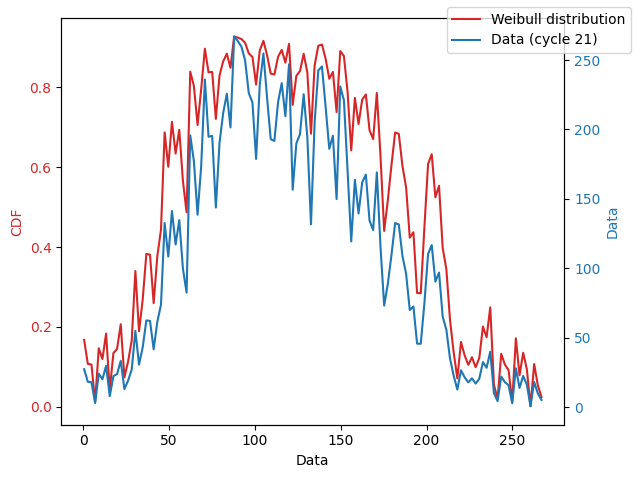

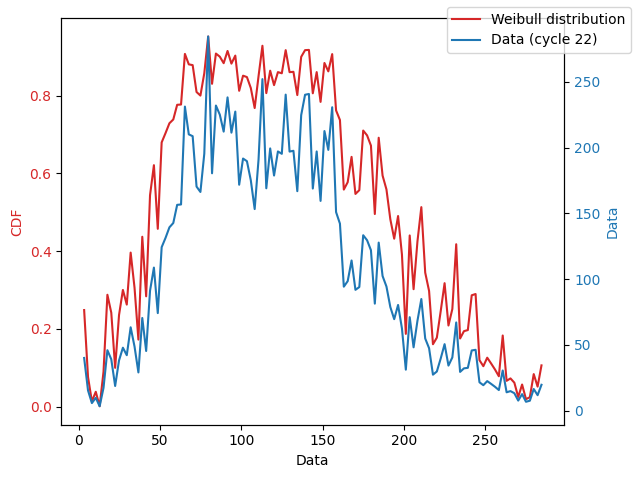

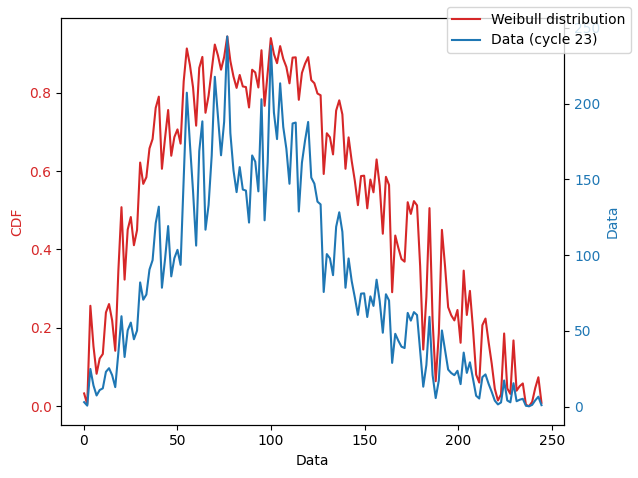

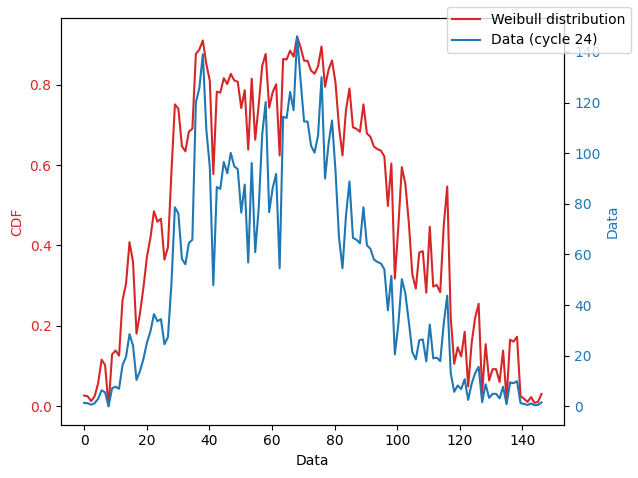

In [17]:
for i in [20, 21, 22, 23]:
    c=table.alfa[i]
    loc=table.beta[i]
    scale=table.mu[i]

    x = np.linspace(min(cycle[i]), max(cycle[i]), len(cycle[i]))
    y_cdf = weibull_min.cdf(cycle[i], c, loc, scale) 

    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Data')
    ax1.set_ylabel('CDF', color=color)
    ax1.plot(x, y_cdf, label='Weibull distribution', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Data', color=color)
    ax2.plot(x, cycle[i], label='Data (cycle ' + str(i+1) + ')', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    fig.legend()
    plt.show()


## Побудова матриці близькості

Побудова матриці близькості на основі таблиць із описовою статистикою (table, table_L, table_R) з використанням Евклідової відстані.

In [18]:
distance_matrix = np.zeros((len(table), len(table)))

for i in range(len(table)):
    for j in range(len(table)):
        distance_matrix[i, j] = euclidean(table.values[i], table.values[j])
        print(distance_matrix[i, j], end = '\t')
    print()

0.0	113.05695432410228	245.47121173666972	141.44031511091094	108.95822648973312	102.43668211415034	21.604682372483854	195.6647177711313	138.76635742045278	74.94523706244865	132.59145421859515	46.2215307289108	48.508681356428355	45.87163513133919	85.28102517303941	23.738151715489646	119.15040377948337	145.64004786028977	241.88991385445303	45.84947280060353	150.56606664500435	146.56234580234343	82.50053996525921	61.702604432877436	141.46994294690444	
113.05695432410228	0.0	142.4043807635504	66.0918023130626	219.38172566066137	201.29091698804592	121.94415816441523	88.94560433467807	56.160368341048326	51.92724484942289	64.46514688412047	150.19389442015685	101.51006523193101	140.35973115907981	67.52454753105786	112.35900215403305	29.041057951351615	45.14897742899363	137.2423871681964	84.09420840487896	64.84142562296121	49.098663375057654	65.38646543578966	166.71307837277138	218.60849007957393	
245.47121173666972	142.4043807635504	0.0	123.0126126200993	344.5982100486898	311.9494716947827	251

In [19]:
distance_matrix_L = np.zeros((len(table_L), len(table_L)))

for i in range(len(table_L)):
    for j in range(len(table_L)):
        distance_matrix_L[i, j] = euclidean(table_L.values[i], table_L.values[j])
        print(distance_matrix_L[i, j], end = '\t')
    print()

0.0	99.14133808491816	249.30699566582865	197.63787558550524	91.98985530723193	132.5844222532859	23.83078757270815	206.89749229974638	129.84849331193465	82.67532590386112	141.19519062906622	50.866240213573256	111.22806575721785	39.144604846797655	87.47887696147231	76.65824079142575	67.61904787623754	136.2499304257001	289.63878223491184	53.833390096982946	145.5155208760423	156.19399018722996	150.53860945155847	40.477728639718805	107.04911706679077	
99.14133808491816	0.0	170.91037723939408	119.932459540418	177.0478242572919	218.95883471305098	118.97623314668759	122.58043261427044	71.13132810663456	70.76369396924558	56.108726565890585	102.99438097585228	73.95060783522118	110.95216044521997	59.841211877576065	98.78435440849906	73.12619239598018	62.260693680640294	207.21832581187746	81.16090332236215	78.34514408112189	72.34767682565564	86.63877125739614	130.30845703467483	188.2513575608936	
249.30699566582865	170.91037723939408	0.0	145.3275333983687	330.48856694002785	347.6909089150641	266.9

In [20]:
distance_matrix_R = np.zeros((len(table_R), len(table_R)))

for i in range(len(table_R)):
    for j in range(len(table_R)):
        distance_matrix_R[i, j] = euclidean(table_R.values[i], table_R.values[j])
        print(distance_matrix_R[i, j], end = '\t')
    print()

0.0	128.56292507116788	161.55290355034643	126.14199647808667	131.96512015645598	95.47168541565522	30.16548776264193	140.0596453083097	165.30810847761313	92.33347451144286	128.95472911121988	70.45793668702069	59.775951891813236	60.54672265361794	55.24273162334595	39.77659860464981	148.18822114386393	162.71977622848004	182.2569680366107	59.968199124228235	156.4491545645007	129.69318176070328	68.70854118260984	92.40316674875474	
128.56292507116788	0.0	41.955090629028966	62.29677807134342	256.12140090185096	201.6748626941078	129.84087450669435	19.415159951999915	47.17809627181213	56.09020644522912	71.89502020860567	182.53908914389422	153.0379133983709	150.28975902527614	91.75261022021495	140.52664759141817	23.66207306595981	45.33147412624215	64.00215390070093	84.70547843595277	53.3560809150838	40.84028750307672	127.13156649810396	211.2961458925758	
161.55290355034643	41.955090629028966	0.0	75.29218354182231	287.4519801888149	230.33316102121134	162.26993805060258	31.725126059822323	49.25193

Побудова матриці близькості на основі фрактальних показників.

In [21]:
distance_matrix_fr = np.zeros((len(fract), len(fract)))

for i in range(len(fract)):
    for j in range(len(fract)):
        distance_matrix_fr[i, j] = euclidean(fract.values[i], fract.values[j])
        print(distance_matrix_fr[i, j], end = '\t')
    print()

0.0	384.30393386272215	1904.3191390307206	2872.3660956694575	176.37278228364443	503.0414950412805	104.54992763672705	1596.4459419483758	1657.7249748619636	1044.2178369341286	2380.203235506959	346.1168959196524	815.6075459454046	237.24737083998625	576.421149249439	282.26289675974374	1244.636204930042	1861.6863675973464	3458.886084272045	848.7757171387339	2337.823305152112	1885.8953823626134	1925.0241464651415	164.75435082239883	1680.1917378787216	
384.30393386272215	0.0	1521.16400928221	2490.0509854242086	560.6684430508509	887.0650826002908	279.87198823106837	1213.370819969411	1275.4997955745905	661.9909128785505	1997.6163223532737	49.56086168769051	434.46223814466515	149.8737541216635	193.95175308510167	103.07590124654085	861.8715931731155	1478.7897081453948	3076.01370255843	467.1500136894608	1954.9863748797845	1502.9449976457797	1542.7343308021113	220.45883441482525	2061.3014063320607	
1904.3191390307206	1521.16400928221	0.0	969.9032167884629	2080.3770094528913	2407.258377589719	1800.

In [22]:
distance_matrix_fr_L = np.zeros((len(fract_L), len(fract_L)))

for i in range(len(fract_L)):
    for j in range(len(fract_L)):
        distance_matrix_fr_L[i, j] = euclidean(fract_L.values[i], fract_L.values[j])
        print(distance_matrix_fr_L[i, j], end = '\t')
    print()

0.0	449.578470269343	208.58551698238642	229.53981287401555	211.89743943993741	598.3847213875273	123.08497105185856	334.27826255452095	67.28408036534356	167.31698787720237	52.63605891889406	359.3880485106755	281.10399546639155	542.4650711031344	195.22743333651394	218.32427800990874	126.01159086778912	75.04935372365148	1045.7086880348459	121.36389445411304	329.9733991134658	77.32507091526983	395.2465014246287	152.35382889678814	793.3536478463207	
449.578470269343	0.0	645.4466389696057	671.2899123922225	241.61397171661727	156.03467741770635	572.3643638715101	776.9961478437547	506.02009730666026	611.2949765696006	437.68115250291095	92.54656214015235	168.7091626854375	96.0518919073497	255.39625409975167	231.35538888127297	328.34979811067683	390.83090041828444	1491.8411127534762	330.286447887001	774.2043150586885	503.7677092486459	842.5769534089718	297.35249817141414	345.298232374727	
208.58551698238642	645.4466389696057	0.0	31.573017974122546	416.1883682594847	798.3079043211509	101.96735836

In [23]:
distance_matrix_fr_R = np.zeros((len(fract_R), len(fract_R)))

for i in range(len(fract_R)):
    for j in range(len(fract_R)):
        distance_matrix_fr_R[i, j] = euclidean(fract_R.values[i], fract_R.values[j])
        print(distance_matrix_fr_R[i, j], end = '\t')
    print()

0.0	808.6135315577687	1677.0513094929522	2498.559724693405	218.13926272522062	26.525593004000616	40.55502358125382	1265.3631040360222	1528.0755780081688	863.9540945250951	2351.075646703133	438.34959692804733	803.3425145675585	764.0590602107917	753.1257596994509	343.2180069451814	1284.155783400048	1881.000217530923	2242.74338807754	962.3695953199106	2012.6940761981978	1821.3303786203903	1028.332800577865	119.12820426779903	
808.6135315577687	0.0	868.5181274203438	1690.3493653014473	1026.5166757443578	807.4954751976044	847.1500779327521	456.8641414294198	719.8042365033846	59.101279744036724	1542.6927416143724	370.9181277205791	35.990814512870955	53.70993719534666	56.59241157685618	465.4887402358661	475.78313828752164	1072.514967778752	1434.218559023544	155.95641769542289	1204.194092177762	1012.851856354477	220.65665494135692	690.0888819168715	
1677.0513094929522	868.5181274203438	0.0	822.4741458885882	1894.8489647920715	1675.634280632937	1715.5744900508923	411.7134125550101	150.727672727

## Побудова дендрограми

Дендрограми на основі матриць близькості із описової статистики для повних циклів (dend) та гілок зростання (dend_L) та спадання (dend_R)

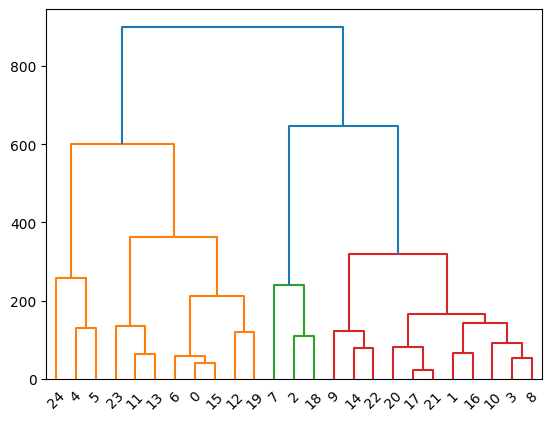

In [24]:
Z = linkage(pdist(distance_matrix), method='complete')

dend = dendrogram(Z)

Визначення кількості кластерів з дендрограми за допомогою методу силуету.

In [25]:
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, n_init='auto')
    kmeans.fit(distance_matrix)
    silhouette_scores.append(silhouette_score(distance_matrix, kmeans.labels_))

optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
print("Optimal number of clusters:", optimal_clusters)

clusters = fcluster(Z, optimal_clusters, criterion='maxclust')

# Додатково виводимо номер кластеру, до якого належить об'єкт з індексом idx
idx = 24
print(f"Об'єкт з індексом {idx} належить до кластеру {clusters[idx]}")

# Визначення об'єктів, які належать до кластеру з індексом 1
cluster_idx = clusters[idx]
objects_in_cluster = [i for i, cluster in enumerate(clusters) if cluster == cluster_idx]
print(f"Об'єкти, що належать до кластеру {cluster_idx}: {objects_in_cluster}")

Optimal number of clusters: 2
Об'єкт з індексом 24 належить до кластеру 1
Об'єкти, що належать до кластеру 1: [0, 4, 5, 6, 11, 12, 13, 15, 19, 23, 24]


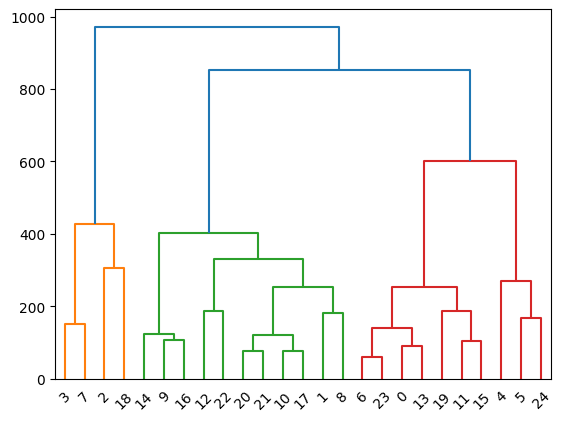

In [26]:
Z_L = linkage(pdist(distance_matrix_L), method='complete')

dend_L = dendrogram(Z_L)

In [27]:
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, n_init='auto')
    kmeans.fit(distance_matrix_L)
    silhouette_scores.append(silhouette_score(distance_matrix_L, kmeans.labels_))

optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
print("Optimal number of clusters:", optimal_clusters)

clusters = fcluster(Z_L, optimal_clusters, criterion='maxclust')

idx = 24
print(f"Об'єкт з індексом {idx} належить до кластеру {clusters[idx]}")

cluster_idx = clusters[idx]
objects_in_cluster = [i for i, cluster in enumerate(clusters) if cluster == cluster_idx]
print(f"Об'єкти, що належать до кластеру {cluster_idx}: {objects_in_cluster}")

Optimal number of clusters: 4
Об'єкт з індексом 24 належить до кластеру 4
Об'єкти, що належать до кластеру 4: [4, 5, 24]


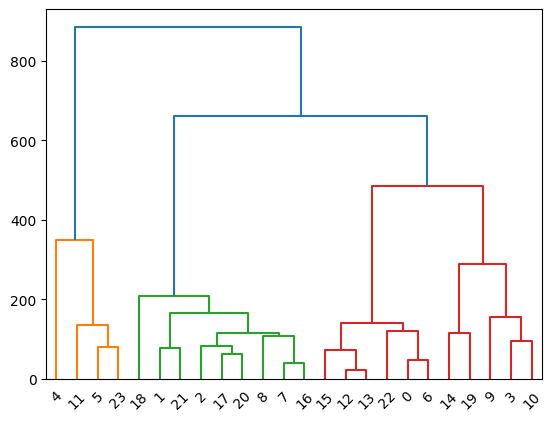

In [28]:
Z_R = linkage(pdist(distance_matrix_R), method='complete')

dend_R = dendrogram(Z_R)

In [29]:
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, n_init='auto')
    kmeans.fit(distance_matrix_R)
    silhouette_scores.append(silhouette_score(distance_matrix_R, kmeans.labels_))

optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
print("Optimal number of clusters:", optimal_clusters)

clusters = fcluster(Z_R, optimal_clusters, criterion='maxclust')

idx = 22
print(f"Об'єкт з індексом {idx} належить до кластеру {clusters[idx]}")

cluster_idx = clusters[idx]
objects_in_cluster = [i for i, cluster in enumerate(clusters) if cluster == cluster_idx]
print(f"Об'єкти, що належать до кластеру {cluster_idx}: {objects_in_cluster}")

Optimal number of clusters: 2
Об'єкт з індексом 22 належить до кластеру 2
Об'єкти, що належать до кластеру 2: [0, 1, 2, 3, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


Побудова дендрограми на основі фрактальних показників.

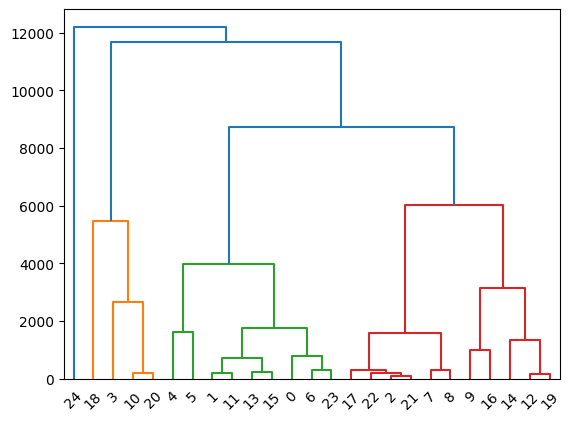

In [30]:
Z_fr = linkage(pdist(distance_matrix_fr), method='complete')

dend_fr = dendrogram(Z_fr)

In [31]:
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, n_init='auto')
    kmeans.fit(distance_matrix_fr)
    silhouette_scores.append(silhouette_score(distance_matrix_fr, kmeans.labels_))

optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
print("Optimal number of clusters:", optimal_clusters)

clusters = fcluster(Z_fr, optimal_clusters, criterion='maxclust')

idx = 22
print(f"Об'єкт з індексом {idx} належить до кластеру {clusters[idx]}")

cluster_idx = clusters[idx]
objects_in_cluster = [i for i, cluster in enumerate(clusters) if cluster == cluster_idx]
print(f"Об'єкти, що належать до кластеру {cluster_idx}: {objects_in_cluster}")

Optimal number of clusters: 3
Об'єкт з індексом 22 належить до кластеру 2
Об'єкти, що належать до кластеру 2: [0, 1, 2, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 19, 21, 22, 23]


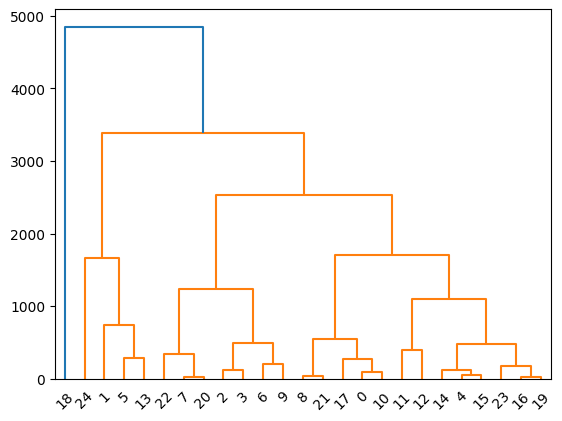

In [32]:
Z_fr_L = linkage(pdist(distance_matrix_fr_L), method='complete')

dend_fr_L = dendrogram(Z_fr_L)

In [33]:
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, n_init='auto')
    kmeans.fit(distance_matrix_fr_L)
    silhouette_scores.append(silhouette_score(distance_matrix_fr_L, kmeans.labels_))

optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
print("Optimal number of clusters:", optimal_clusters)

clusters = fcluster(Z_fr_L, optimal_clusters, criterion='maxclust')

idx = 0
print(f"Об'єкт з індексом {idx} належить до кластеру {clusters[idx]}")

cluster_idx = clusters[idx]
objects_in_cluster = [i for i, cluster in enumerate(clusters) if cluster == cluster_idx]
print(f"Об'єкти, що належать до кластеру {cluster_idx}: {objects_in_cluster}")

Optimal number of clusters: 2
Об'єкт з індексом 0 належить до кластеру 1
Об'єкти, що належать до кластеру 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24]


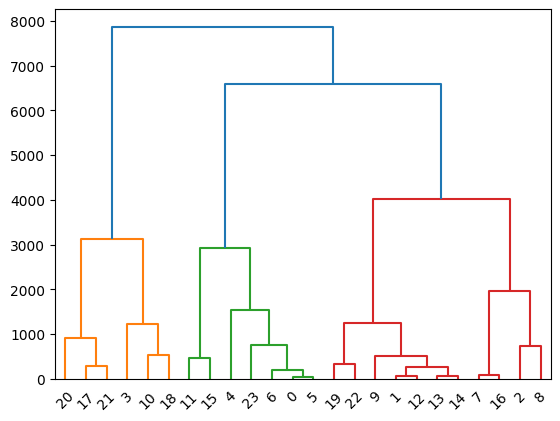

In [34]:
Z_fr_R = linkage(pdist(distance_matrix_fr_R), method='complete')

dend_fr_R = dendrogram(Z_fr_R)

In [35]:
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, n_init='auto')
    kmeans.fit(distance_matrix_fr_R)
    silhouette_scores.append(silhouette_score(distance_matrix_fr_R, kmeans.labels_))

optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
print("Optimal number of clusters:", optimal_clusters)

clusters = fcluster(Z_fr_R, optimal_clusters, criterion='maxclust')

idx = 22
print(f"Об'єкт з індексом {idx} належить до кластеру {clusters[idx]}")

cluster_idx = clusters[idx]
objects_in_cluster = [i for i, cluster in enumerate(clusters) if cluster == cluster_idx]
print(f"Об'єкти, що належать до кластеру {cluster_idx}: {objects_in_cluster}")

Optimal number of clusters: 8
Об'єкт з індексом 22 належить до кластеру 6
Об'єкти, що належать до кластеру 6: [1, 9, 12, 13, 14, 19, 22]
